# Trouble shooting in low performance MV-SuSIE

In [ ]:
library("dplyr")
library("tibble")
library("readr")
library("purrr")
library("tidyr")
library("ggplot2")

## MV SuSiE with low performance

In [103]:
phenotype = c("Asthma","diabetes","WAIST")
tissue = read_delim("~/Project/one_gene/passed_tissue",delim = "\t",col_names = F)$X1
working = tibble(tissue = rep(tissue,3))%>%mutate(phenotype = c(rep(phenotype[1],8),rep(phenotype[2],8),rep(phenotype[3],8)),
                                                 path = map2(phenotype,tissue,~paste(c("/mnt/mfs/statgen/neuro-twas/JAZF1/AT_result/",.x,".sumstat/",.y,"/result/",.x,"_chr7.twas.txt"),collapse = "")),
                                                 data = map(path,~read_delim(.x,delim = "\t"))
                                                 )


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PANEL = col_logical(),
  FILE = col_character(),
  ID = col_character(),
  BEST.GWAS.ID = col_character(),
  EQTL.ID = col_logical(),
  EQTL.R2 = col_logical(),
  EQTL.Z = col_logical(),
  EQTL.GWAS.Z = col_logical(),
  MODEL = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PANEL = col_logical(),
  FILE = col_character(),
  ID = col_character(),
  BEST.GWAS.ID = col_character(),
  EQTL.ID = col_logical(),
  EQTL.R2 = col_logical(),
  EQTL.Z = col_logical(),
  EQTL.GWAS.Z = col_logical(),
  MODEL = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────

In [104]:
result_mv = working%>%select(-path)%>%unnest(data)%>%select(-c(FILE:P1),-PANEL,-HSQ,-c(EQTL.ID:EQTL.GWAS.Z))%>%mutate(TWAS.P.Adj = p.adjust(TWAS.P))
result_mv%>%filter(TWAS.P.Adj < 0.05)

tissue,phenotype,BEST.GWAS.ID,BEST.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P,TWAS.P.Adj
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Artery_Tibial,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0095,0.34,-5.22,1.77e-07,3.3630e-06
Liver,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0650,0.25,-7.28,3.22e-13,7.7280e-12
Lung,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0110,0.35,-6.35,2.11e-10,4.2200e-09
Muscle_Skeletal,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0320,0.13,-6.76,1.37e-11,3.0140e-10
Spleen,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0290,0.33,-7.03,2.09e-12,4.8070e-11
Stomach,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0041,0.42,-6.40,1.56e-10,3.2760e-09
Whole_Blood,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0290,0.20,-4.79,1.65e-06,2.8050e-05
Artery_Tibial,diabetes,chr7_28154778_C_A_b38,-8.9,6083,6083,mv_susie,0.0095,0.34,-4.09,4.40e-05,5.2800e-04
Liver,diabetes,chr7_28154778_C_A_b38,-8.9,6083,6083,mv_susie,0.0650,0.25,-4.85,1.26e-06,2.2680e-05


Problem:
1. MV SuSiE Performance is poorer than that of the FUSION result

Potential Source of problems:
1. Patterns are not shared among selected tissues
2. Some informations are encoded in the Rare variantes that are omitted

## Result for FUSION
This step extract the SNVs with non-zero lasso weights 


In [107]:
dir = "/home/hs3163/Project/one_gene/" 
tissue = read_delim("/home/hs3163/Project/one_gene/passed_tissue",delim = "\t",col_names = F )
tissue = tissue%>%mutate(path = map_chr(X1,~paste(c(dir,.x,"/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat"),collapse = "" )),
                env = map(path,~attach(.x)),
                best_m = map_dbl(env,~which(.x$cv.performance[2,] == min(.x$cv.performance[2,]))%>%as.numeric)         
               )
fusion_data = tissue%>%mutate(Wgt_mtrix = map2(best_m,env,~.y$wgt.matrix[,.x]),
                         best_pval = map_dbl(env,~min(.x$cv.performance[2,])%>%as.numeric())
                        )
fusion_vis_pos = fusion_data%>%mutate(tissue = X1,Wgt_mtrix = map(Wgt_mtrix, ~.x%>%as_tibble%>%mutate(pos = 1:32230)))%>%unnest(Wgt_mtrix)


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character()
)


The following objects are masked from file:/home/hs3163/Project/one_gene/Artery_Tibial/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq, hsq.pv, N.tot, snps, wgt.matrix


The following objects are masked from file:/home/hs3163/Project/one_gene/Liver/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq, hsq.pv, N.tot, snps, wgt.matrix


The following objects are masked from file:/home/hs3163/Project/one_gene/Artery_Tibial/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq, hsq.pv, N.tot, snps, wgt.matrix


The following objects are masked from file:/home/hs3163/Project/one_gene/Lung/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq, hsq.pv, N.tot, snps, wgt.matrix


The following objects are masked from file:/home/hs3163/Project/one_gene/Liver/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq,

In [108]:
snps = fusion_data$Wgt_mtrix[[1]]%>%names
snps%>%length()

[1] 32230

In [109]:
fusion_data = fusion_data%>%mutate(SNP = map2(env,best_m,~.x$wgt.matrix%>%as_tibble(rownames = "SNP")%>%filter(lasso != 0 )%>%pull("SNP")))
fusion_data%>%select(-env,-path,-Wgt_mtrix )

X1,best_m,best_pval,SNP
<chr>,<dbl>,<dbl>,<list>
Artery_Tibial,3,0.36542621,"chr7_28021673_C_A_b38, chr7_28148187_C_T_b38, chr7_28220789_G_A_b38, chr7_28279976_G_C_b38, chr7_29123047_T_C_b38"
Liver,3,0.03346111,"chr7_27201832_A_AC_b38 , chr7_27211031_C_G_b38 , chr7_27437256_G_T_b38 , chr7_27442072_G_A_b38 , chr7_27540805_A_G_b38 , chr7_27555503_C_G_b38 , chr7_27558502_T_C_b38 , chr7_27567155_T_C_b38 , chr7_27577873_G_C_b38 , chr7_27580690_G_T_b38 , chr7_27632059_A_T_b38 , chr7_27656133_T_C_b38 , chr7_27704216_C_T_b38 , chr7_27784849_G_T_b38 , chr7_27930275_A_G_b38 , chr7_27933901_T_C_b38 , chr7_28092776_C_T_b38 , chr7_28116609_AT_A_b38 , chr7_28117268_C_T_b38 , chr7_28121414_C_G_b38 , chr7_28129126_GTCTT_G_b38, chr7_28132447_T_C_b38 , chr7_28132967_T_C_b38 , chr7_28133120_T_G_b38 , chr7_28199847_A_G_b38 , chr7_28219614_T_C_b38 , chr7_28230016_C_T_b38 , chr7_28403670_A_G_b38 , chr7_28579245_C_T_b38 , chr7_28668848_T_C_b38"
Lung,3,0.27695198,"chr7_27472535_CCCG_C_b38, chr7_28209675_A_C_b38 , chr7_28356857_C_T_b38 , chr7_28386557_G_A_b38 , chr7_28641606_A_T_b38 , chr7_28993192_T_C_b38 , chr7_29023176_C_T_b38 , chr7_29025002_C_T_b38 , chr7_29091682_CAA_C_b38"
Muscle_Skeletal,3,0.02394978,"chr7_27503710_T_C_b38, chr7_27523034_G_C_b38, chr7_27574409_T_G_b38, chr7_27993323_T_C_b38, chr7_28116987_C_G_b38, chr7_28118439_C_T_b38, chr7_28149792_T_C_b38, chr7_28216621_G_A_b38, chr7_28320447_T_C_b38, chr7_28513710_A_G_b38, chr7_28513868_A_G_b38, chr7_28993421_G_A_b38"
Spleen,3,0.23607770,
Stomach,4,0.43275125,"chr7_27223249_A_T_b38, chr7_27224284_G_A_b38, chr7_27224559_C_T_b38, chr7_27225809_G_A_b38, chr7_27228286_G_A_b38, chr7_27370950_G_T_b38, chr7_27407666_G_A_b38, chr7_28269469_A_T_b38, chr7_28400046_G_A_b38, chr7_29009538_T_C_b38, chr7_29013885_A_G_b38"
Thyroid,3,0.33383781,"chr7_28652599_T_G_b38, chr7_28660950_C_T_b38"
Whole_Blood,4,0.01092036,"chr7_27193395_C_A_b38 , chr7_27196005_CT_C_b38, chr7_27277730_G_T_b38 , chr7_27290669_G_A_b38 , chr7_27296922_T_G_b38 , chr7_27468966_T_G_b38 , chr7_27590854_C_T_b38 , chr7_27794316_T_G_b38 , chr7_28233453_G_C_b38 , chr7_28237488_C_G_b38 , chr7_28377595_C_A_b38 , chr7_28838425_C_G_b38 , chr7_28923847_A_C_b38"


In [110]:
susie_dirr = "/mnt/mfs/statgen/neuro-twas/"
class = c("uni_non","uni_rare","uni")
susie_df = tibble(tissue = tissue$X1, "uni_non","uni_rare","uni")

In [111]:
susie_df = susie_df%>%pivot_longer(col = `"uni_non"`:`"uni"`, names_to  = "dis", values_to = "class")%>%select(-dis)

In [112]:
susie_df = susie_df%>%mutate(path = map2_chr(tissue,class, ~ paste(c(susie_dirr,"JAZF1_",.y,"/",.x,"/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData"),collapse = "") ), 
                  env = map(path,~attach(.x))            
                 )

The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_uni_non/Artery_Tibial/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData:

    fitted1


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_uni_rare/Artery_Tibial/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData:

    fitted1


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_uni_non/Artery_Tibial/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData:

    fitted1


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_uni/Artery_Tibial/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData:

    fitted1


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_uni_rare/Artery_Tibial/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData:

    fitted1


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_uni_non/Artery_Tibial/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData:

    fitted1


The following object is 

In [113]:
susie_df = susie_df%>%mutate(model = map(env,~.x$fitted1) ,
                            pval =  map_dbl(model,~.x$pval),
                            sets = map(model, ~.x$sets),
                            cs = map(sets,~.x$cs),
                            cs_named = map2(cs,model,~(.y$X_column_scale_factors%>%names())[.x%>%unlist])
                            )

## Result of Uni-variate SuSIE
This step looks at the performance and credible sets using different filter:
1. Uni: 0.01 missing allele frequency filter
2. uni_rare: 0.0015 MAF
3. uni_non: No Filter

The changes of filter doesnt not seems to have a huge impact in Liver performance, but on Muscel Skeleton & Whole Blood

In [47]:
susie_df%>%select(-env,-model,-sets,-path)

tissue,class,pval,cs,cs_named
<chr>,<chr>,<dbl>,<list>,<list>
Artery_Tibial,uni_non,0.29450373,NULL,
Artery_Tibial,uni_rare,0.31265426,NULL,
Artery_Tibial,uni,0.42136436,NULL,
Liver,uni_non,0.05418317,"8315, 8319, 8328, 8361, 8424, 8441, 8451, 8456, 8458, 8492, 8502, 9005, 9165","chr7_28116987_C_G_b38 , chr7_28117268_C_T_b38 , chr7_28118439_C_T_b38 , chr7_28121414_C_G_b38 , chr7_28129126_GTCTT_G_b38, chr7_28130784_T_C_b38 , chr7_28132447_T_C_b38 , chr7_28132967_T_C_b38 , chr7_28133120_T_G_b38 , chr7_28136686_G_A_b38 , chr7_28137682_C_T_b38 , chr7_28199847_A_G_b38 , chr7_28219614_T_C_b38"
Liver,uni_rare,0.05524906,"8315, 8319, 8328, 8361, 8424, 8441, 8451, 8456, 8458, 8492, 8502, 9005, 9165","chr7_28116987_C_G_b38 , chr7_28117268_C_T_b38 , chr7_28118439_C_T_b38 , chr7_28121414_C_G_b38 , chr7_28129126_GTCTT_G_b38, chr7_28130784_T_C_b38 , chr7_28132447_T_C_b38 , chr7_28132967_T_C_b38 , chr7_28133120_T_G_b38 , chr7_28136686_G_A_b38 , chr7_28137682_C_T_b38 , chr7_28199847_A_G_b38 , chr7_28219614_T_C_b38"
Liver,uni,0.06554036,"3117, 3119, 3122, 3138, 3163, 3171, 3174, 3177, 3179, 3190, 3196, 3396, 3463","chr7_28116987_C_G_b38 , chr7_28117268_C_T_b38 , chr7_28118439_C_T_b38 , chr7_28121414_C_G_b38 , chr7_28129126_GTCTT_G_b38, chr7_28130784_T_C_b38 , chr7_28132447_T_C_b38 , chr7_28132967_T_C_b38 , chr7_28133120_T_G_b38 , chr7_28136686_G_A_b38 , chr7_28137682_C_T_b38 , chr7_28199847_A_G_b38 , chr7_28219614_T_C_b38"
Lung,uni_non,0.21729714,NULL,
Lung,uni_rare,0.20343996,NULL,
Lung,uni,0.21705562,NULL,


## Analysis of overlapped SNVs
1 out of the 9 non-zero lasso is filtered out by MAF.

In [144]:
vis_rare = susie_df

In [145]:
vis_rare = vis_rare%>%mutate(pip = map(model,~.x$pip%>%as_tibble(rownames = "SNP")%>%mutate( pos = map_dbl(SNP,~which(snps == .x) )) ))

In [147]:
major_allele = vis_rare%>%select(-env,-model,-sets,-path)%>%unnest(pip)%>%filter(class == "uni_non")%>%pull(SNP)%>%unique()
Lung_lasso = (fusion_data%>%select(-env,-path,-Wgt_mtrix )%>%pull(SNP))[[3]]
Lung_snps = which(snps%in%Lung_lasso )

In [148]:
Common_variant = susie_df$env[[3]]$fitted1$X_column_scale_factors%>%names
Rare_variant = susie_df$env[[2]]$fitted1$X_column_scale_factors%>%names

In [149]:
Lung_lasso%in%Common_variant
Lung_lasso%in%Rare_variant

[1]  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [23]:
intersect(fusion_data%>%filter(X1 == "Muscle_Skeletal")%>%pull(SNP)%>%unlist,susie_df%>%filter(tissue == "Muscle_Skeletal",class == "uni")%>%pull(cs_named)%>%unlist)

[1] "chr7_28149792_T_C_b38" "chr7_28216621_G_A_b38"

In [55]:
intersect(fusion_data%>%filter(X1 == "Liver")%>%pull(SNP)%>%unlist,susie_df%>%filter(tissue == "Liver",class == "uni")%>%pull(cs_named)%>%unlist)

[1] "chr7_28117268_C_T_b38"     "chr7_28121414_C_G_b38"    
[3] "chr7_28129126_GTCTT_G_b38" "chr7_28132447_T_C_b38"    
[5] "chr7_28132967_T_C_b38"     "chr7_28133120_T_G_b38"    
[7] "chr7_28199847_A_G_b38"     "chr7_28219614_T_C_b38"

## Visualization of PIP
PIP: The probabilities that this variant is one of the eQtls

Red line representing the posistion of the 9 SNVs

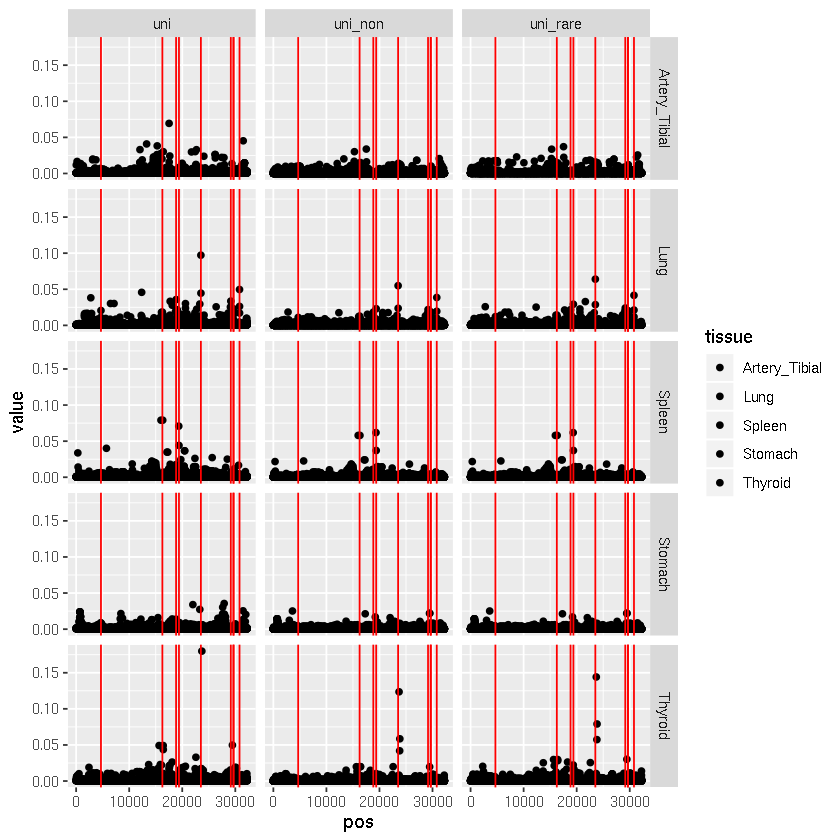

In [55]:
vis_rare%>%unnest(pip)%>%filter(!tissue %in% c("Liver","Muscle_Skeletal","Whole_Blood"))%>%ggplot(aes(x = pos, y = value,fill = tissue))+geom_point()+geom_vline(xintercept = Lung_snps,colour = "red")+facet_grid(tissue~class)

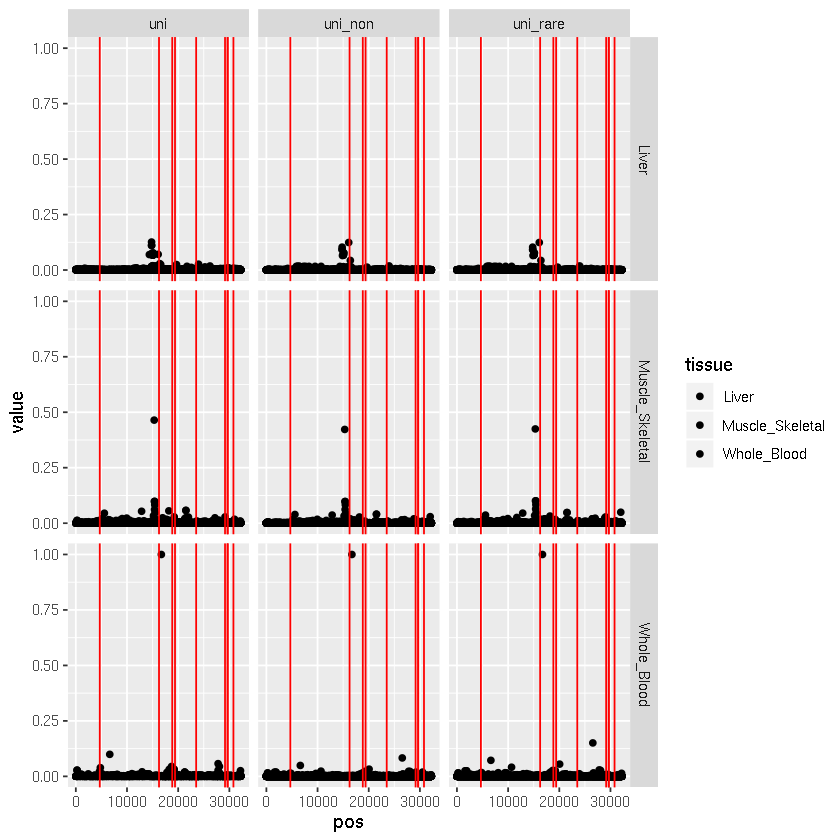

In [135]:
vis_rare%>%unnest(pip)%>%filter(tissue %in% c("Liver","Muscle_Skeletal","Whole_Blood"))%>%ggplot(aes(x = pos, y = value,fill = tissue))+geom_point()+geom_vline(xintercept = Lung_snps,colour = "red")+facet_grid(tissue~class)

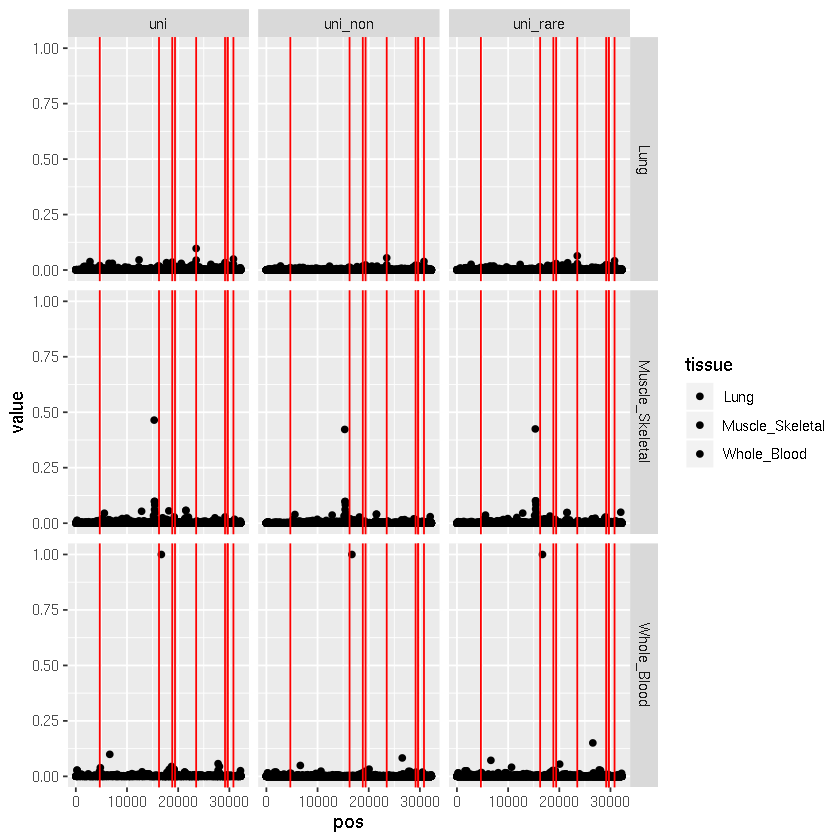

In [136]:
vis_rare%>%unnest(pip)%>%filter(tissue %in% c("Lung","Muscle_Skeletal","Whole_Blood"))%>%ggplot(aes(x = pos, y = value,fill = tissue))+geom_point()+geom_vline(xintercept = Lung_snps,colour = "red")+facet_grid(tissue~class)

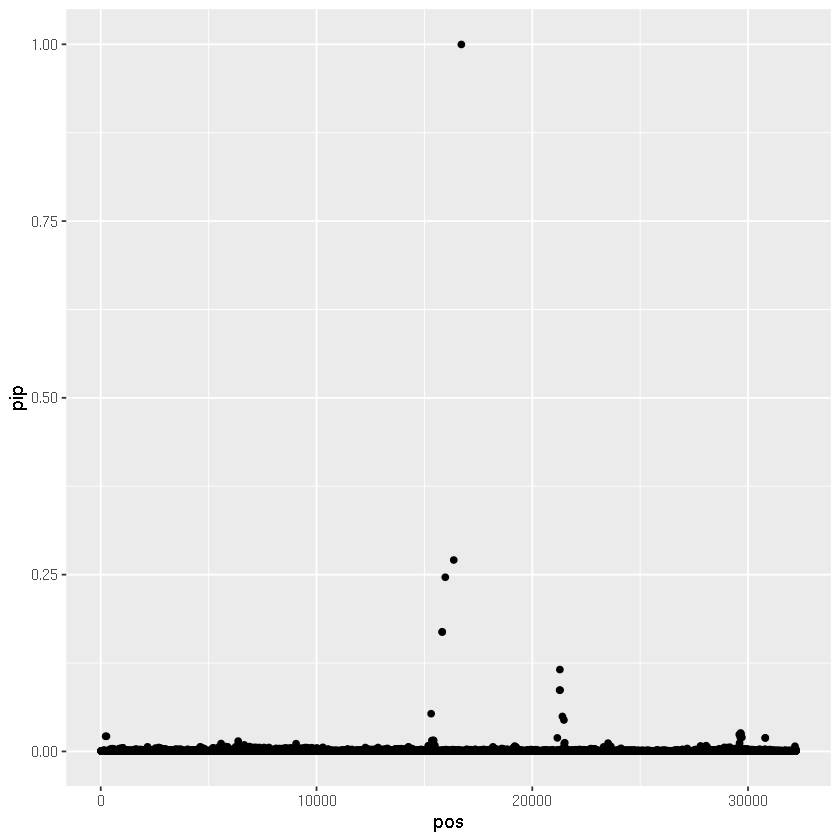

In [33]:
hisample_pip%>%ggplot(aes(x = pos, y = pip))+geom_point()

In [62]:
vis_rare%>%unnest(pip)%>%select(SNP,class,tissue,value)%>%filter(class == "uni_non")%>%count(tissue)
vis_rare%>%unnest(pip)%>%select(SNP,class,tissue,value)%>%filter(class == "uni_rare")%>%count(tissue)
vis_rare%>%unnest(pip)%>%select(SNP,class,tissue,value)%>%filter(class == "uni")%>%count(tissue)

tissue,n
<chr>,<int>
Artery_Tibial,27944
Liver,18020
Lung,25862
Muscle_Skeletal,29990
Spleen,19624
Stomach,21638
Thyroid,27149
Whole_Blood,29240


tissue,n
<chr>,<int>
Artery_Tibial,16157
Liver,18020
Lung,15128
Muscle_Skeletal,14212
Spleen,19624
Stomach,21638
Thyroid,15605
Whole_Blood,13925


tissue,n
<chr>,<int>
Artery_Tibial,7677
Liver,7232
Lung,7509
Muscle_Skeletal,7592
Spleen,8100
Stomach,7836
Thyroid,7552
Whole_Blood,7719


## Complete case and imputed correlations of pip

In [48]:
pip = vis_rare%>%unnest(pip)%>%select(SNP,class,tissue,value)%>%filter(class == "uni")%>%select(-class)%>%pivot_wider(names_from = tissue,values_from = value)%>%select(-SNP)%>%as.matrix()

In [80]:
pip%>%na.omit%>%cor

,Artery_Tibial,Liver,Lung,Muscle_Skeletal,Spleen,Stomach,Thyroid,Whole_Blood
Artery_Tibial,1.000000000,-0.012788343,0.044131201,0.045055002,-0.019093462,0.140757428,0.003255764,-0.002966182
Liver,-0.012788343,1.000000000,0.073152948,0.006777659,0.099597079,-0.021013777,-0.003888603,-0.004217175
Lung,0.044131201,0.073152948,1.000000000,0.023387111,0.070761079,0.013747699,0.073219186,0.001932516
Muscle_Skeletal,0.045055002,0.006777659,0.023387111,1.000000000,0.030681516,-0.002399417,-0.004517612,0.001431752
Spleen,-0.019093462,0.099597079,0.070761079,0.030681516,1.000000000,-0.006468083,0.016123202,0.003267537
Stomach,0.140757428,-0.021013777,0.013747699,-0.002399417,-0.006468083,1.000000000,-0.007947805,0.002259562
Thyroid,0.003255764,-0.003888603,0.073219186,-0.004517612,0.016123202,-0.007947805,1.000000000,-0.005113670
Whole_Blood,-0.002966182,-0.004217175,0.001932516,0.001431752,0.003267537,0.002259562,-0.005113670,1.000000000


In [63]:
pip%>%saveRDS("/mnt/mfs/statgen/neuro-twas/one_gene_pip.rds")

In [68]:
cor = readRDS("/mnt/mfs/statgen/neuro-twas/one_gene_cor.rds")
colnames(cor) = tissue$X1 
rownames(cor) = tissue$X1

In [71]:
cor

,Artery_Tibial,Liver,Lung,Muscle_Skeletal,Spleen,Stomach,Thyroid,Whole_Blood
Artery_Tibial,1.00000000,0.114454111,0.20731520,0.064124662,0.17934371,0.23899666,0.14965228,0.017158773
Liver,0.11445411,1.000000000,0.10461608,0.032367378,0.09049341,0.12060966,0.07552619,0.005007544
Lung,0.20731520,0.104616078,1.00000000,0.058613856,0.16395216,0.21847459,0.13679923,0.018118855
Muscle_Skeletal,0.06412466,0.032367378,0.05861386,1.000000000,0.05070221,0.06757388,0.04231448,0.003257879
Spleen,0.17934371,0.090493413,0.16395216,0.050702210,1.00000000,0.18899965,0.11834094,0.017752492
Stomach,0.23899666,0.120609663,0.21847459,0.067573884,0.18899965,1.00000000,0.15770542,0.019141890
Thyroid,0.14965228,0.075526188,0.13679923,0.042314484,0.11834094,0.15770542,1.00000000,0.010847621
Whole_Blood,0.01715877,0.005007544,0.01811886,0.003257879,0.01775249,0.01914189,0.01084762,1.000000000


In [81]:
pip = pip%>%as_tibble

In [86]:
lm(Lung~Liver+Artery_Tibial+Muscle_Skeletal+Spleen+Stomach+Thyroid+Whole_Blood ,data = pip)%>%summary


Call:
lm(formula = Lung ~ Liver + Artery_Tibial + Muscle_Skeletal + 
    Spleen + Stomach + Thyroid + Whole_Blood, data = pip)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.010405 -0.000611 -0.000525 -0.000161  0.048486 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     9.906e-04  4.296e-05  23.060  < 2e-16 ***
Liver           3.884e-02  7.030e-03   5.525 3.41e-08 ***
Artery_Tibial   5.054e-02  1.428e-02   3.539 0.000404 ***
Muscle_Skeletal 6.488e-03  4.094e-03   1.585 0.113118    
Spleen          7.008e-02  1.363e-02   5.143 2.78e-07 ***
Stomach         1.353e-02  1.661e-02   0.815 0.415172    
Thyroid         5.449e-02  9.174e-03   5.939 3.01e-09 ***
Whole_Blood     4.292e-04  2.128e-03   0.202 0.840149    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.002158 on 6597 degrees of freedom
  (2167 observations deleted due to missingness)
Multiple R-squared:  0.01726,	Adjusted R-sq

## Factor with high weights

In [49]:
plot_sharing = function(X, to_cor=FALSE, title="", remove_names=F) {
    clrs <- colorRampPalette(rev(c("#D73027","#FC8D59","#FEE090","#FFFFBF",
                                   "#E0F3F8","#91BFDB","#4575B4")))(128)
    if (to_cor) lat <- cov2cor(X)
    else lat = X/max(diag(X))
    lat[lower.tri(lat)] <- NA
    n <- nrow(lat)
    if (remove_names) {
      colnames(lat) = NULL
      rownames(lat) = NULL
    }
    return(lattice::levelplot(lat[n:1,],col.regions = clrs,
                            xlab = "",ylab = "", main=title,
                            colorkey = TRUE,at = seq(-1,1,length.out = 128),
                            scales = list(cex = 0.6,x = list(rot = 45))))
} 



In [14]:
Prior = readRDS("~/Project//one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds")

In [57]:
tibble(W = Prior$w, name = Prior$w%>%names())%>%arrange(-W)%>%head

W,name
<dbl>,<chr>
0.44725973,tFLASH_nonneg
0.41843579,XtX
0.01421486,tFLASH_default
0.01391240,Thyroid
0.01288158,FLASH_nonneg_4
0.01129455,tPCA


,Artery_Tibial,Liver,Lung,Muscle_Skeletal,Spleen,Stomach,Thyroid,Whole_Blood
Artery_Tibial,1.0000000,0.8195949,0.9229095,0.8275579,0.8480262,0.9390087,0.8926797,0.6392274
Liver,0.8195949,1.0000000,0.8678637,0.7629977,0.8265157,0.8894022,0.8440073,0.6412453
Lung,0.9229095,0.8678637,1.0000000,0.8054128,0.9227741,0.9528020,0.9191427,0.7446328
Muscle_Skeletal,0.8275579,0.7629977,0.8054128,1.0000000,0.7289297,0.8273048,0.7647393,0.5731490
Spleen,0.8480262,0.8265157,0.9227741,0.7289297,1.0000000,0.9061512,0.8817669,0.7783451
Stomach,0.9390087,0.8894022,0.9528020,0.8273048,0.9061512,1.0000000,0.9337751,0.6746245
Thyroid,0.8926797,0.8440073,0.9191427,0.7647393,0.8817669,0.9337751,1.0000000,0.6263559
Whole_Blood,0.6392274,0.6412453,0.7446328,0.5731490,0.7783451,0.6746245,0.6263559,1.0000000


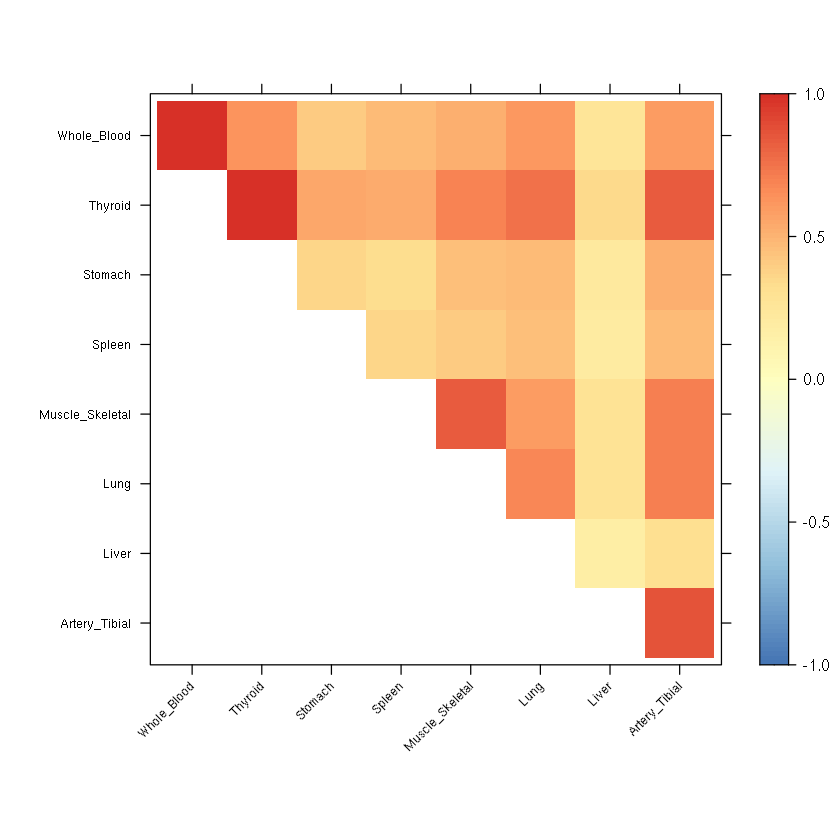

In [64]:
plot_sharing(Prior$U$tFLASH_nonneg)
Prior$U$tFLASH_nonneg%>%cov2cor

,Artery_Tibial,Liver,Lung,Muscle_Skeletal,Spleen,Stomach,Thyroid,Whole_Blood
Artery_Tibial,1.0000000,0.6568408,0.8353998,0.7073576,0.7378191,0.8301600,0.7785747,0.6069038
Liver,0.6568408,1.0000000,0.7471001,0.6177797,0.7209363,0.7920307,0.7135427,0.5884787
Lung,0.8353998,0.7471001,1.0000000,0.6922667,0.8700762,0.8892255,0.8496198,0.7385889
Muscle_Skeletal,0.7073576,0.6177797,0.6922667,1.0000000,0.6106828,0.7113392,0.6446856,0.5252104
Spleen,0.7378191,0.7209363,0.8700762,0.6106828,1.0000000,0.8306870,0.7939538,0.7990027
Stomach,0.8301600,0.7920307,0.8892255,0.7113392,0.8306870,1.0000000,0.8483820,0.6753747
Thyroid,0.7785747,0.7135427,0.8496198,0.6446856,0.7939538,0.8483820,1.0000000,0.6143034
Whole_Blood,0.6069038,0.5884787,0.7385889,0.5252104,0.7990027,0.6753747,0.6143034,1.0000000


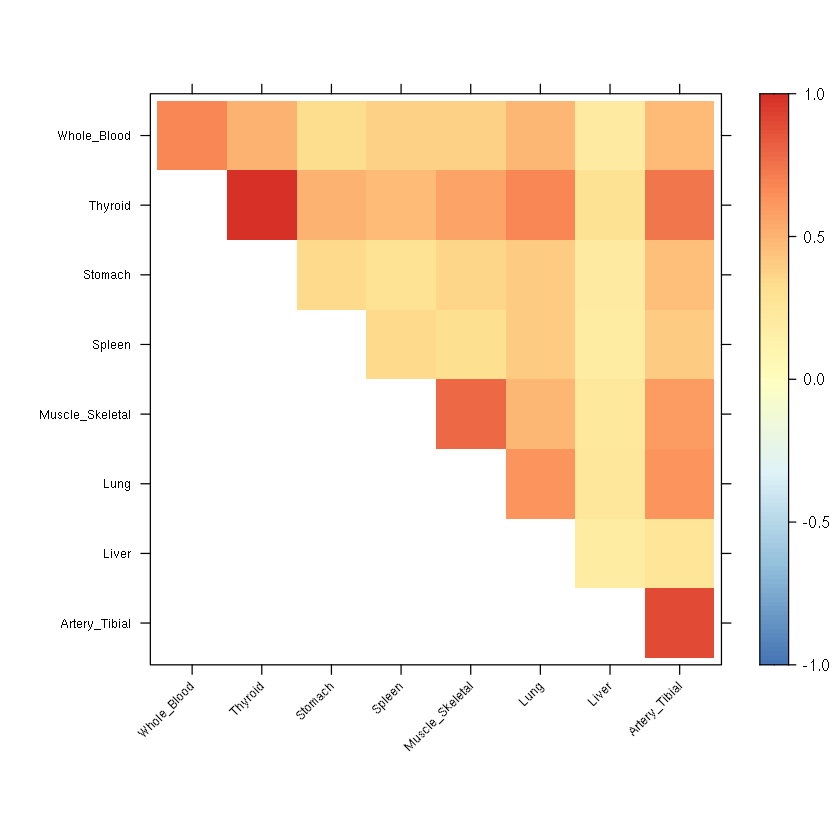

In [65]:
plot_sharing(Prior$U$XtX)
Prior$U$XtX%>%cov2cor

## MV_susie result

## Selected by Lasso Sig
'Artery_Tibial',   'Liver',   'Lung',  'Muscle_Skeletal', 'Whole_Blood'   

In [6]:
lasso_prior = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_4ted//result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData")

The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_selected/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData:

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 4):

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 5):

    full_model




In [7]:
lasso_prior$full_model$pval

V1        V2        V3        V4        V5 
0.3374289 0.2829178 0.3455457 0.1436286 0.1846613

## Selected by pip association 
'Artery_Tibial',   'Liver',   'Lung',   'Spleen'   'Thyroid'

In [34]:
selected_prior = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_selected/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData")

The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_4ted//result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData:

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_selected/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 18):

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 19):

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 20):

    full_model




In [35]:
selected_default = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_selected_default//result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData")

The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_selected/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 3):

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_4ted//result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData:

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_selected/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 19):

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 20):

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 21):

    full_model




In [45]:
selected_prior$full_model$pval
selected_default$full_model$pval

V1        V2        V3        V4        V5 
0.3457928 0.2718153 0.3093498 0.3588592 0.4455453

V1        V2        V3        V4        V5 
0.3576130 0.3031324 0.2788214 0.2527047 0.4174022

In [37]:
selected_prior_pip = tibble(pip = selected_prior$full_model$pip, SNPs = selected_prior$full_model$variable_names, pos = which(snps%in%selected_prior$full_model$snps))

In [38]:
selected_defaul_pip = tibble(pip = selected_default$full_model$pip, SNPs = selected_default$full_model$variable_names, pos = which(snps%in%selected_default$full_model$snps))

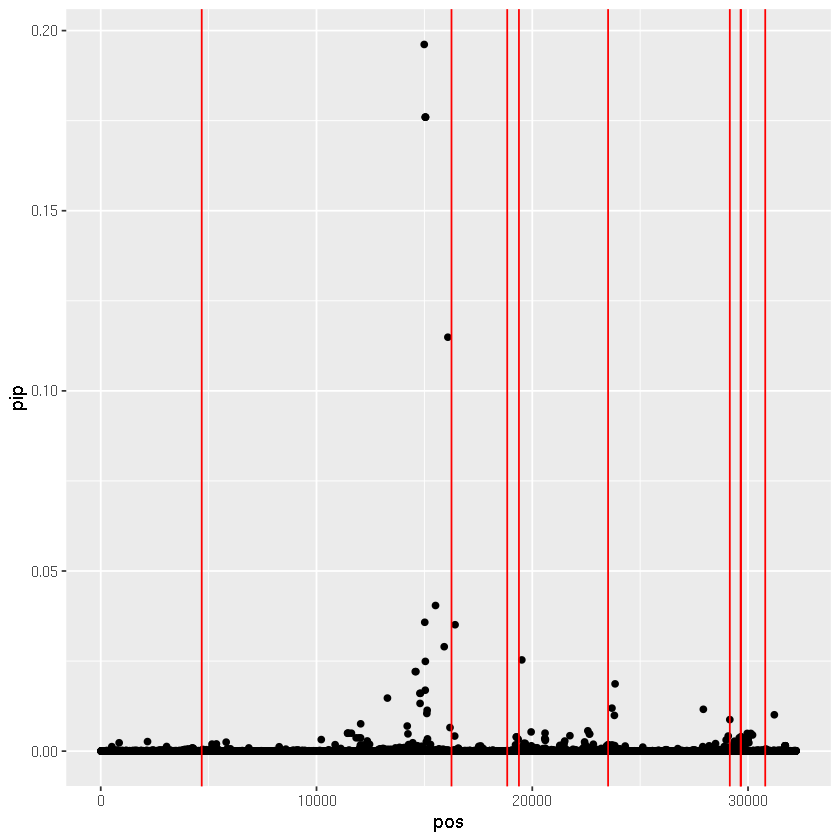

In [56]:
selected_prior_pip%>%ggplot(aes(x = pos, y = pip))+geom_point()+geom_vline(xintercept = Lung_snps,colour = "red")

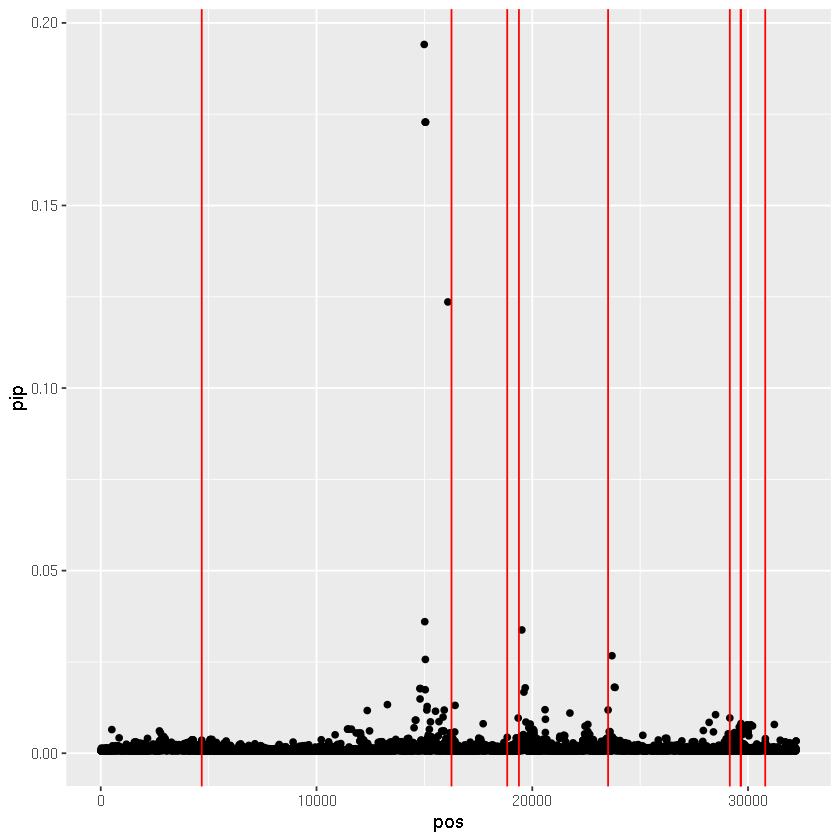

In [57]:
selected_defaul_pip%>%ggplot(aes(x = pos, y = pip))+geom_point()+geom_vline(xintercept = Lung_snps,colour = "red")

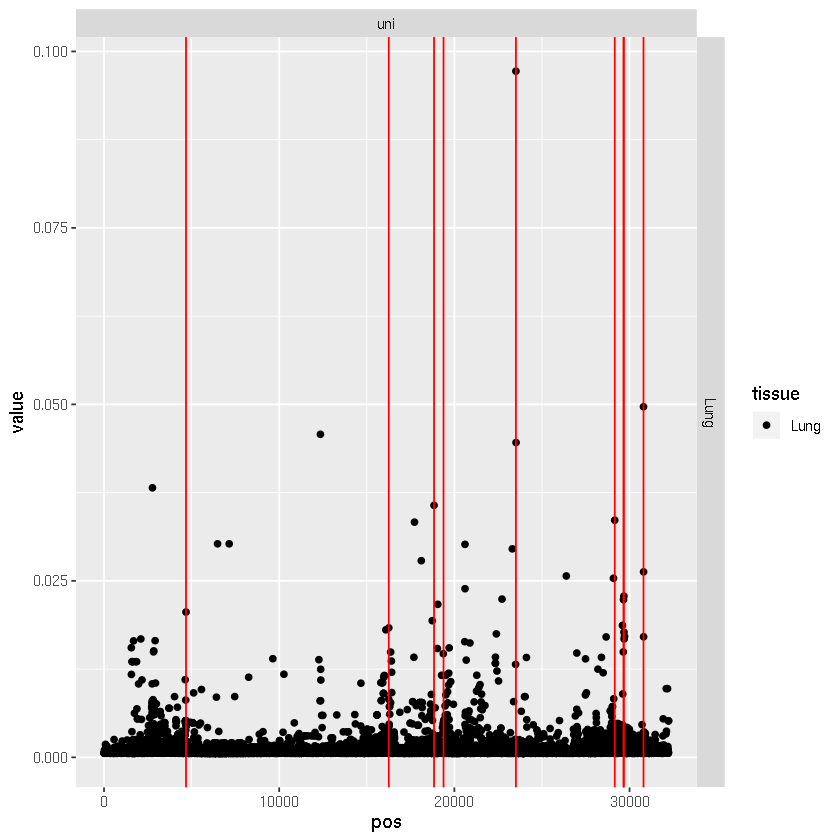

In [60]:
vis_rare%>%unnest(pip)%>%filter(tissue %in% "Lung",class == "uni")%>%ggplot(aes(x = pos, y = value,fill = tissue))+geom_point()+geom_vline(xintercept = Lung_snps,colour = "red")+facet_grid(tissue~class)

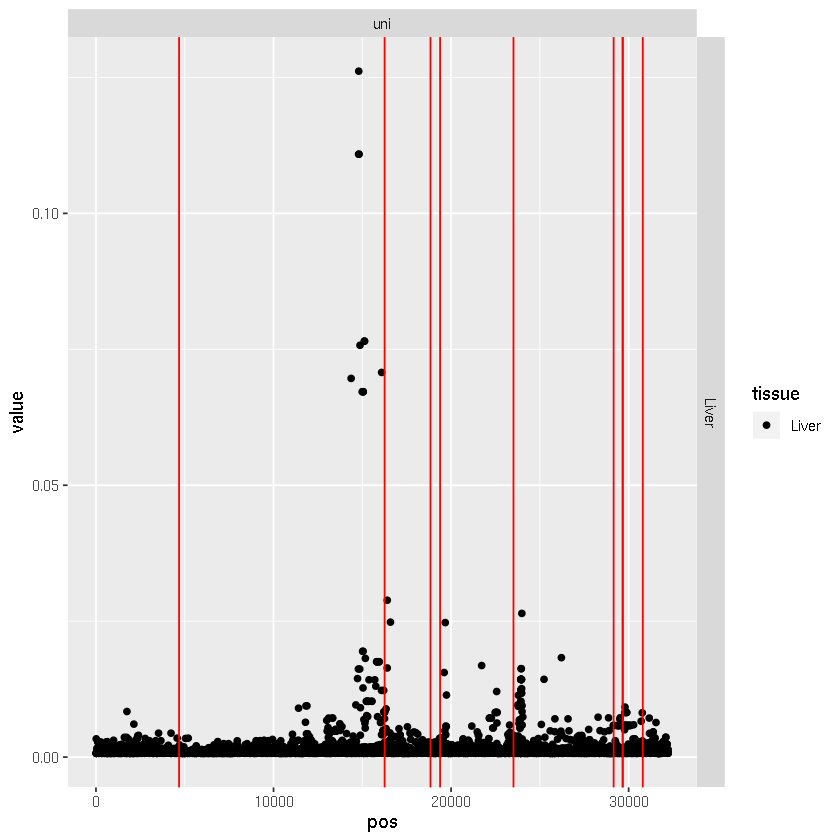

In [61]:
vis_rare%>%unnest(pip)%>%filter(tissue %in% "Liver",class == "uni")%>%ggplot(aes(x = pos, y = value,fill = tissue))+geom_point()+geom_vline(xintercept = Lung_snps,colour = "red")+facet_grid(tissue~class)

## Tissue selected by prior 
'Artery_Tibial',  'Lung',    'Thyroid'

In [ ]:
tissue3 = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_3T/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData")

In [43]:
tissue3$full_model$pval 
tissue3_default$full_model$pval

V1        V2        V3 
0.3314693 0.3224631 0.4884918

V1        V2        V3 
0.3420167 0.2773241 0.4546785

## Tissue selected by High sample overlapped 
"Lung","Whole Blood", "Mus"

In [2]:
hisample_default = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData")

The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 3):

    full_model




In [10]:
names(hisample_default$full_model$pval) = c("Lung",'Muscle_Skeletal', 'Whole_Blood')
names(lasso_prior$full_model$pval) = c('Artery_Tibial',   'Liver',   'Lung',  'Muscle_Skeletal', 'Whole_Blood'   )




In [29]:
hisample_default$full_model$r2
lasso_prior$full_model$r2

V1         V2         V3 
0.01700324 0.03227119 0.03023432

V1          V2          V3          V4          V5 
0.012484153 0.057674553 0.008876366 0.032205630 0.030950841

In [26]:
hisample_default$full_model$pos = which(snps%in%hisample_default$full_model$snps)

In [30]:
hisample_pip = tibble(pip = hisample_default$full_model$pip, SNPs = hisample_default$full_model$variable_names, pos = hisample_default$full_model$pos)

In [31]:
hisample_pip 

pip,SNPs,pos
<dbl>,<chr>,<int>
0.0007193812,chr7_27181168_CCG_C_b38,12
0.0007193812,chr7_27181172_CTT_C_b38,13
0.0007193812,chr7_27181175_T_A_b38,14
0.0005490431,chr7_27181212_A_G_b38,16
0.0005987184,chr7_27181446_CT_C_b38,21
0.0005101161,chr7_27181608_C_T_b38,26
0.0004874001,chr7_27181835_C_A_b38,30
0.0005309494,chr7_27181837_G_A_b38,31
0.0004950224,chr7_27181886_G_A_b38,34


## Looking at samples

In [ ]:
Exp = read_delim("/mnt/mfs/statgen/neuro-twas/JAZF1/cache/GTEx_V8.ENSG00000153814.merged.exp",delim = "\t")
colnames(Exp) = c("Sample",colnames(Prior$U$tFLASH_nonneg))

In [17]:
Exp%>%pull(Liver)%>%na.omit()%>%length

[1] 208

In [20]:
Exp%>%na.omit()

Sample,Artery_Tibial,Liver,Lung,Muscle_Skeletal,Spleen,Stomach,Thyroid,Whole_Blood
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GTEX-11EQ9:GTEX-11EQ9,0.19184550,-0.37436340,-0.66840360,0.18722380,-0.33603810,0.54665560,-0.5776828,1.37253900
GTEX-131XE:GTEX-131XE,-0.58182620,-0.53405800,-1.10897300,0.54115360,-0.98512760,1.08725700,-0.7288606,-1.07991800
GTEX-17HHE:GTEX-17HHE,0.17876830,-0.05399669,-0.19060230,-1.38222600,-0.08806557,-0.11206830,-0.2443542,-0.94870240
GTEX-18A66:GTEX-18A66,0.48305060,0.27321360,0.76254230,-0.14767080,-1.18291700,-0.33389140,0.4435177,0.20883730
GTEX-1JMLX:GTEX-1JMLX,-0.89152130,0.90845790,1.74264700,0.07274569,1.35493400,0.36669550,0.9802626,1.48664400
GTEX-1KD5A:GTEX-1KD5A,1.55621000,1.02318600,2.88808400,-0.26361160,0.60698680,1.22244700,2.3783290,1.30833400
GTEX-1LGRB:GTEX-1LGRB,-0.18312380,0.06601181,-0.43606340,2.27961000,0.56779310,-1.54198600,1.2965600,0.77531760
GTEX-OIZF:GTEX-OIZF,0.05358607,0.18698210,-0.15608120,-0.66893640,0.70235770,0.12760500,1.6931090,-1.04703800
GTEX-OOBJ:GTEX-OOBJ,0.22688540,-0.18698210,-0.37800570,-0.61234250,-0.26699410,-1.14476200,-1.1492940,-0.71129710


In [21]:
Exp%>%pivot_longer(names_to = "tissue",values_to = "exp", cols =Artery_Tibial:Whole_Blood )%>%group_by(tissue)%>%summarise(Present = 1-is.na(exp)%>%mean,Samples = sum(!is.na(exp)))

tissue,Present,Samples
<chr>,<dbl>,<int>
Artery_Tibial,0.7019231,584
Liver,0.2500000,208
Lung,0.6189904,515
Muscle_Skeletal,0.8485577,706
Spleen,0.2728365,227
Stomach,0.3894231,324
Thyroid,0.6899038,574
Whole_Blood,0.8052885,670


In [22]:
Exp%>%select(-Sample)%>%is.na%>%cor

,Artery_Tibial,Liver,Lung,Muscle_Skeletal,Spleen,Stomach,Thyroid,Whole_Blood
Artery_Tibial,1.00000000,0.078887910,0.13261551,0.22314184,0.086504152,0.20249202,0.14825241,0.07771594
Liver,0.07888791,1.000000000,0.17289861,0.08904501,-0.004673799,-0.03984676,0.09301763,-0.01051467
Lung,0.13261551,0.172898608,1.00000000,0.08279853,0.058282895,0.04794959,0.19102343,0.02047848
Muscle_Skeletal,0.22314184,0.089045009,0.08279853,1.00000000,0.063060083,0.04859430,0.17344996,0.02088309
Spleen,0.08650415,-0.004673799,0.05828289,0.06306008,1.000000000,0.34089124,0.08396201,0.05587611
Stomach,0.20249202,-0.039846763,0.04794959,0.04859430,0.340891239,1.00000000,0.11442174,0.05656171
Thyroid,0.14825241,0.093017629,0.19102343,0.17344996,0.083962012,0.11442174,1.00000000,-0.03435794
Whole_Blood,0.07771594,-0.010514672,0.02047848,0.02088309,0.055876113,0.05656171,-0.03435794,1.00000000


In [23]:
Exp%>%filter(!is.na(Lung))%>%pivot_longer(names_to = "tissue",values_to = "exp", cols =Artery_Tibial:Whole_Blood )%>%group_by(tissue)%>%summarise(Present = 1-is.na(exp)%>%mean)

tissue,Present
<chr>,<dbl>
Artery_Tibial,0.7495146
Liver,0.3087379
Lung,1.0000000
Muscle_Skeletal,0.8718447
Spleen,0.2932039
Stomach,0.4077670
Thyroid,0.7592233
Whole_Blood,0.8116505


In [27]:
Exp%>%select(Lung,Muscle_Skeletal)%>%na.omit%>%nrow
Exp%>%select(Lung,Muscle_Skeletal,Whole_Blood)%>%na.omit%>%nrow
Exp%>%select(Lung,Artery_Tibial,Thyroid,Lung,Spleen)%>%na.omit%>%nrow
Exp%>%select(Lung,Artery_Tibial,Thyroid)%>%na.omit%>%nrow
Exp%>%select(Lung,Artery_Tibial,Thyroid,Muscle_Skeletal,Whole_Blood)%>%na.omit%>%nrow
Exp%>%select(Lung,Thyroid,Muscle_Skeletal,Whole_Blood)%>%na.omit%>%nrow

[1] 449

[1] 366

[1] 88

[1] 303

[1] 228

[1] 280

In [28]:
0.8*c(
Exp%>%select(Lung,Muscle_Skeletal)%>%na.omit%>%nrow
,Exp%>%select(Lung,Muscle_Skeletal,Whole_Blood)%>%na.omit%>%nrow
,Exp%>%select(Lung,Artery_Tibial,Thyroid,Lung,Spleen)%>%na.omit%>%nrow
,Exp%>%select(Lung,Artery_Tibial,Thyroid)%>%na.omit%>%nrow
,Exp%>%select(Lung,Artery_Tibial,Thyroid,Muscle_Skeletal,Whole_Blood)%>%na.omit%>%nrow
,Exp%>%select(Lung,Thyroid,Muscle_Skeletal,Whole_Blood)%>%na.omit%>%nrow
)

[1] 359.2 292.8  70.4 242.4 182.4 224.0

In [137]:
Exp%>%filter(!is.na(Liver))%>%pivot_longer(names_to = "tissue",values_to = "exp", cols =Artery_Tibial:Whole_Blood )%>%group_by(tissue)%>%summarise(Present = 1-is.na(exp)%>%mean)

tissue,Present
<chr>,<dbl>
Artery_Tibial,0.7644231
Liver,1.0000000
Lung,0.7644231
Muscle_Skeletal,0.9038462
Spleen,0.2692308
Stomach,0.3557692
Thyroid,0.7644231
Whole_Blood,0.7980769


## For references

In [3]:
exp_alz = read_delim("/mnt/mfs//statgen/neuro-twas/mv_wg/cache/geneTpmResidualsAgeGenderAdj_rename.ENSG00000000419.merged.exp",delim = "\t")


── Column specification ────────────────────────────────────────────────────────
cols(
  name = col_character(),
  V6.x = col_double(),
  V6.y = col_double(),
  V6 = col_double()
)




In [11]:
colnames(exp_alz )= c("Sample","AC","PCC","DLPFC")
exp_alz%>%pivot_longer(names_to = "tissue",values_to = "exp", cols =AC:DLPFC )%>%group_by(tissue)%>%summarise(Present = 1-is.na(exp)%>%mean,Samples = sum(!is.na(exp)))
exp_alz%>%na.omit()%>%nrow

tissue,Present,Samples
<chr>,<dbl>,<int>
AC,0.7394209,664
DLPFC,0.9465479,850
PCC,0.5868597,527


[1] 415

## Diagnosis of MV_SuSiE

In [2]:
Prior = readRDS("~/Project//one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds")

In [3]:
tissue = Prior$U$Artery_Tibial%>%colnames()

In [36]:
mtr = matrix(0, nrow = 8, ncol = 8,dimnames = list(tissue,tissue))

In [60]:
loop = tibble(tissue = tissue, mtr = replicate(8, mtr, simplify=FALSE)) 

In [67]:
mtr

,Artery_Tibial,Liver,Lung,Muscle_Skeletal,Spleen,Stomach,Thyroid,Whole_Blood
Artery_Tibial,0,0,0,0,0,0,0,0
Liver,0,0,0,0,0,0,0,0
Lung,0,0,0,0,0,0,0,0
Muscle_Skeletal,0,0,0,0,0,0,0,0
Spleen,0,0,0,0,0,0,0,0
Stomach,0,0,0,0,0,0,0,0
Thyroid,0,0,0,0,0,0,0,0
Whole_Blood,0,0,0,0,0,0,0,0


In [64]:
mtr_list =  replicate(8, mtr, simplify=FALSE)

In [71]:
mtr_list

,Artery_Tibial,Liver,Lung,Muscle_Skeletal,Spleen,Stomach,Thyroid,Whole_Blood
Artery_Tibial,1,0,0,0,0,0,0,0
Liver,0,0,0,0,0,0,0,0
Lung,0,0,0,0,0,0,0,0
Muscle_Skeletal,0,0,0,0,0,0,0,0
Spleen,0,0,0,0,0,0,0,0
Stomach,0,0,0,0,0,0,0,0
Thyroid,0,0,0,0,0,0,0,0
Whole_Blood,0,0,0,0,0,0,0,0
,Artery_Tibial,Liver,Lung,Muscle_Skeletal,Spleen,Stomach,Thyroid,Whole_Blood
Artery_Tibial,0,0,0,0,0,0,0,0


In [96]:
for(i in 1:8){
     mt =   mtr_list[[i]]
    mt[colnames(mt) == tissue[i],colnames(mt) == tissue[i]] = 1
    path = paste(c("~/Project/one_gene/data/GTEx_V8_strong_z.ed_",tissue[i],".rds"),collapse = "")
    print(path)
    obj = list(U = list(sing = mt), w = c(sing = 1), Prior$loglik)
    obj%>%saveRDS(path)
}

[1] "~/Project/one_gene/data/GTEx_V8_strong_z.ed_Artery_Tibial.rds"
[1] "~/Project/one_gene/data/GTEx_V8_strong_z.ed_Liver.rds"
[1] "~/Project/one_gene/data/GTEx_V8_strong_z.ed_Lung.rds"
[1] "~/Project/one_gene/data/GTEx_V8_strong_z.ed_Muscle_Skeletal.rds"
[1] "~/Project/one_gene/data/GTEx_V8_strong_z.ed_Spleen.rds"
[1] "~/Project/one_gene/data/GTEx_V8_strong_z.ed_Stomach.rds"
[1] "~/Project/one_gene/data/GTEx_V8_strong_z.ed_Thyroid.rds"
[1] "~/Project/one_gene/data/GTEx_V8_strong_z.ed_Whole_Blood.rds"


In [86]:
Prior$w

identity   Artery_Tibial           Liver            Lung Muscle_Skeletal 
   9.016748e-04    3.853455e-03    3.619602e-03    3.189019e-03    5.937168e-03 
         Spleen         Stomach         Thyroid     Whole_Blood   equal_effects 
   2.093551e-03    1.894811e-03    1.391240e-02    8.243880e-03    6.182019e-05 
   simple_het_1    simple_het_2    simple_het_3             XtX  tFLASH_default 
   1.398150e-03    2.382333e-03    7.929077e-03    4.184358e-01    1.421486e-02 
FLASH_default_1 FLASH_default_2 FLASH_default_3   tFLASH_nonneg  FLASH_nonneg_1 
   6.056787e-14    0.000000e+00    2.824261e-04    4.472597e-01    2.749319e-03 
 FLASH_nonneg_2  FLASH_nonneg_3  FLASH_nonneg_4  FLASH_nonneg_5  FLASH_nonneg_6 
   1.770342e-03    7.019821e-03    1.288158e-02    2.711432e-03    2.081772e-03 
 FLASH_nonneg_7  FLASH_nonneg_8  FLASH_nonneg_9 FLASH_nonneg_10 FLASH_nonneg_11 
   7.089817e-03    0.000000e+00    4.920787e-03    1.857712e-03    5.657247e-03 
FLASH_nonneg_12 FLASH_nonneg_13 FLASH_nonneg_14 FLASH_nonneg_15 FLASH_nonneg_16 
   1.364762e-03    3.580465e-04    1.370946e-04    9.253264e-04    4.104119e-04 
FLASH_nonneg_17           PCA_1           PCA_2           PCA_3            tPCA 
   1.160226e-03    3.535874e-09    0.000000e+00    0.000000e+00    1.129455e-02

In [87]:
c(a = 1,n = 2)

a n 
1 2

In [63]:
loop1$mtr

[[1]]
[1] "Artery_Tibial"

[[2]]
[1] "Liver"

[[3]]
[1] "Lung"

[[4]]
[1] "Muscle_Skeletal"

[[5]]
[1] "Spleen"

[[6]]
[1] "Stomach"

[[7]]
[1] "Thyroid"

[[8]]
[1] "Whole_Blood"

In [ ]:
for tissue in `cat ~/Project/one_gene/passed_tissue`; do
mkdir $tissue
cd $tissue
nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd /mnt/mfs/statgen/neuro-twas/JAZF1_diag/$tissue/ \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--mixture_prior ~/Project//one_gene/data/GTEx_V8_strong_z.ed_$tissue.rds \
--cv_times 100 \
--MAF 0 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &
cd ..
done



for tissue in `echo Whole_Blood`; do
nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd /mnt/mfs/statgen/neuro-twas/JAZF1_diag/$tissue/ \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--mixture_prior ~/Project//one_gene/data/GTEx_V8_strong_z.ed_$tissue.rds \
--cv_times 100 \
--MAF 0 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_uni_non//Whole_Blood/whole_blood_snps" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &
done



## Joint analysis for the two strong tissue

In [89]:
obj$U[[1]][4,4] = 1

In [91]:
obj$U = list(joint = obj$U[[1]])

In [93]:
obj$w = c(joint = 1)

In [95]:
obj%>%saveRDS("~/Project/one_gene/data/GTEx_V8_strong_z.ed_Joint.rds")

In [ ]:
nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_Joint/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_Joint//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_Joint/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_Joint.rds' \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_Joint/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &




In [ ]:
whole_blood = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_diag/Whole_Blood/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData")
muscel = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_diag/Muscle_Skeletal/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData")

In [ ]:
whole_blood$full_model$variable_names

In [32]:
(!b_snp %in% whole_blood$m_ENSG00000153814$variable_names)%>%sum

[1] 0

In [ ]:
length(whole_blood$full_model$variable_names)

In [195]:
muscel$m_ENSG00000153814$coef%>%as_tibble

V1,V2,V3,V4,V5,V6,V7,V8
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.003965165,-0.05644689,0.002422637,-3.170118e-03,0.1199801,0.0369249,-0.01003622,0.003170499
0.000000000,0.00000000,0.000000000,1.955511e-05,0.0000000,0.0000000,0.00000000,0.000000000
0.000000000,0.00000000,0.000000000,9.458316e-06,0.0000000,0.0000000,0.00000000,0.000000000
0.000000000,0.00000000,0.000000000,-4.322977e-07,0.0000000,0.0000000,0.00000000,0.000000000
0.000000000,0.00000000,0.000000000,-8.111923e-06,0.0000000,0.0000000,0.00000000,0.000000000
0.000000000,0.00000000,0.000000000,-9.047773e-06,0.0000000,0.0000000,0.00000000,0.000000000
0.000000000,0.00000000,0.000000000,1.707112e-06,0.0000000,0.0000000,0.00000000,0.000000000
0.000000000,0.00000000,0.000000000,9.820725e-06,0.0000000,0.0000000,0.00000000,0.000000000
0.000000000,0.00000000,0.000000000,2.911431e-06,0.0000000,0.0000000,0.00000000,0.000000000


In [185]:
muscel$full_model$fitted%>%length

[1] 6656

value,SNPs,pos
<dbl>,<chr>,<int>
0.0007511511,chr7_27181168_CCG_C_b38,12
0.0007511511,chr7_27181172_CTT_C_b38,13
0.0007511511,chr7_27181175_T_A_b38,14
0.0007472003,chr7_27181212_A_G_b38,16
0.0005296060,chr7_27181446_CT_C_b38,21
0.0005064298,chr7_27181608_C_T_b38,26
0.0004910117,chr7_27181835_C_A_b38,30
0.0005001190,chr7_27181837_G_A_b38,31
0.0005768815,chr7_27181886_G_A_b38,34


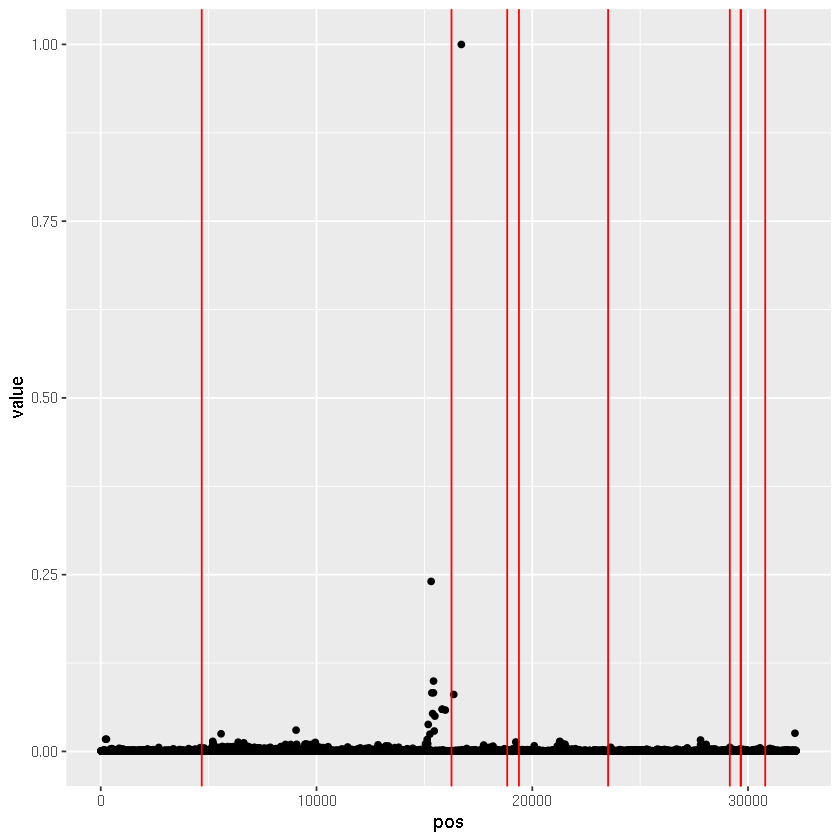

In [154]:
c = a$full_model$pip%>%as_tibble%>%mutate(SNPs = c(a$full_model$variable_names))
c = c%>%mutate(pos = c(which(snps %in% SNPs)))

c%>%ggplot(aes(x = pos, y = value))+geom_point()+geom_vline(xintercept = Lung_snps,colour = "red")

In [37]:
b = attach("/mnt/mfs//statgen/neuro-twas/JAZF1_uni_non/Whole_Blood/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData")

The following object is masked from file:/mnt/mfs//statgen/neuro-twas/JAZF1_uni/Whole_Blood/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData (pos = 3):

    fitted1


The following object is masked from file:/mnt/mfs//statgen/neuro-twas/JAZF1_uni/Whole_Blood/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData (pos = 10):

    fitted1


The following object is masked from file:/mnt/mfs//statgen/neuro-twas/JAZF1_uni_non/Whole_Blood/susie/GTEx_V8.ENSG00000153814.susie.model.cv.RData (pos = 17):

    fitted1


The following object is masked from file:/mnt/mfs//statgen/neuro-twas/JAZF1_uni_non/Whole_Blood/susie/GTEx_V8.ENSG00000153814.susie.model.cv.RData (pos = 18):

    fitted1




In [38]:
b_snp = b$fitted1$X_column_scale_factors%>%names
b_snp%>%length

[1] 29240

In [9]:
b_snp%>%as_tibble%>%write_delim("/mnt/mfs//statgen/neuro-twas/JAZF1_uni_non/Whole_Blood/whole_blood_snps",delim = "\t")

In [4]:
names(b)

[1] "alpha"                  "mu"                     "mu2"                   
 [4] "Xr"                     "KL"                     "lbf"                   
 [7] "lbf_variable"           "sigma2"                 "V"                     
[10] "pi"                     "null_index"             "converged"             
[13] "elbo"                   "niter"                  "intercept"             
[16] "fitted"                 "sets"                   "pip"                   
[19] "X_column_scale_factors" "X"                      "Y"                     
[22] "rmse"                   "r2"                     "r2_raw"                
[25] "pval"

In [179]:
b$pval

V1 
0.03027805

In [180]:
coef_wb = coef(b)

In [181]:
coef_wb%>%length

[1] 29241

In [124]:
coef.susie = function (object, ...) 
{
    s = object
    return(c(s$intercept, colSums(s$alpha * s$mu)/s$X_column_scale_factors))
}

In [129]:
coef.susie(b)%>%as_tibble

value
<dbl>
-4.247045e-17
-4.246876e-05
-4.246876e-05
-4.246876e-05
1.790047e-06
-2.711117e-06
-6.842848e-06
-1.974059e-06
-7.787986e-06


In [127]:
b = b[[1]]

In [ ]:
b